This notebook contains example code for performing impact source localization and visualization. 

We will
1. Load measured signals, and all other meta data 
2. Visualize the measured vibrations at 5 locations created by one impact. 
3. Perform backprojection to localize the impact. 


This example notebook will only load data from `data/isotropic_plasticboard_20cm` If you want to work with other measurements, you might need to change some parameter settings, like the size of the backprojection canvas. 

In [1]:
from src.tilt_signal import Tilt2D, AngleMapping

from src.plot_utils import plot_signals, plot_points, color_mapping, plot_list_func

from src.data_utils import load_from_processed

from src.backproj_solver import BackProjSolver
import copy
import os
import cv2

import numpy as np
import imageio 
import hdf5pickle

%matplotlib notebook
import matplotlib.pyplot as plt

# Load Data

For each board, we fix the measurement location, and we repeatedly knock at a set of known locations, shown below. 

![figure_arr](./assets/figure_points_arrangements.png)

We measure the 2D tilts at points marker-0,1,2,3,4, and we repeatedly knock at points-0, 1, ..., 6. 

We save all the measured vibration, measurement location, impact location and material calibration results in a single .npz file. 

This cell loads the experiment for one board. 


In [2]:
dir_path = "data/isotropic_plasticboard_20cm/"

npz_path = os.path.join(dir_path, 'processed_final.npz')

(all_signal_list, marker_locations, gt_locations_list, 
     gt_loc_list, name_list, DataDict, angle_mapping_obj) = load_from_processed(npz_path, len_first_clip=100, 
                                                             use_optical_scaling=True, shift_signal=False, 
                                                             use_angle_mapping=True)

# corner_locations denote the physical boundary of the board, which is used for visualization purposes
if 'corner_locations' in DataDict:
    corner_locations = DataDict['corner_locations']
else:
    corner_locations = None

marker_names = ["marker-{}".format(i) for i in range(len(marker_locations))]

=> Loading
Signal X of shape : (21, 5, 1808)
Names:  ['point-13' 'point-14' 'point-15' 'point-14' 'point-16' 'point-16'
 'point-15' 'point-12' 'point-18' 'point-17' 'point-14' 'point-17'
 'point-13' 'point-13' 'point-18' 'point-12' 'point-12' 'point-18'
 'point-15' 'point-16' 'point-17']


## Plot the spatial arrangement of the points

To visualize the spatial arrangement of measurement location, and impact location, we plot it. 
* Blue marker indicates measurement locations
* point-x indicates impact locations

<IPython.core.display.Javascript object>


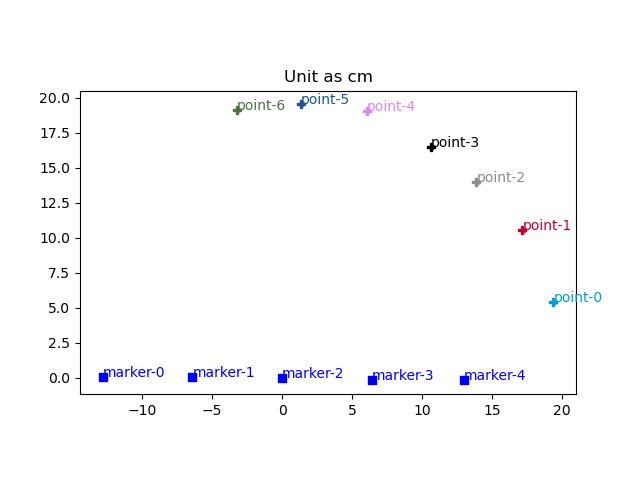

In [3]:
plot_marker_inds = []

plt.figure()
plt.title('Unit as cm')
for i, mxy in enumerate(marker_locations):
    label='marker-{}'.format(i)
    m_color = 'blue'
    
    if i in plot_marker_inds:
        plt.scatter([mxy[0]], mxy[1], color='blue', label=label, marker='s')
        plt.text(mxy[0], mxy[1], s=label, color='blue')
    else:
        
        plt.scatter([mxy[0]], mxy[1], color=m_color, label=label, marker='s')
        plt.text(mxy[0], mxy[1], s=label, color=m_color)

for i, txy in enumerate(gt_loc_list):
    
    if name_list is not None and i < len(name_list):
        label = name_list[i]
    else:
        label = 'knock-{}'.format(i)
    
    label = 'point-{}'.format(i)
    
    plt.scatter([txy[0]], [txy[1]], color=color_mapping[i], label=label, marker='P')
    plt.text(txy[0], txy[1], s=label, color=color_mapping[i])
    

ax = plt.gca()
ax.set_aspect('equal')
  
plt.show()



# Visualize the signals

Now we have measurement at all these 5 markers, for impact at different points. At each point, 
we repeat the impact for a couple of times (2, 3 times). 

Let's start by index one impact using 
* tgt_ind: specify the impact point
* exp_ind: specify which repeat 

Then we can extract measurements from all five markers, and plot them

=> showing 2/3 repeat


<IPython.core.display.Javascript object>


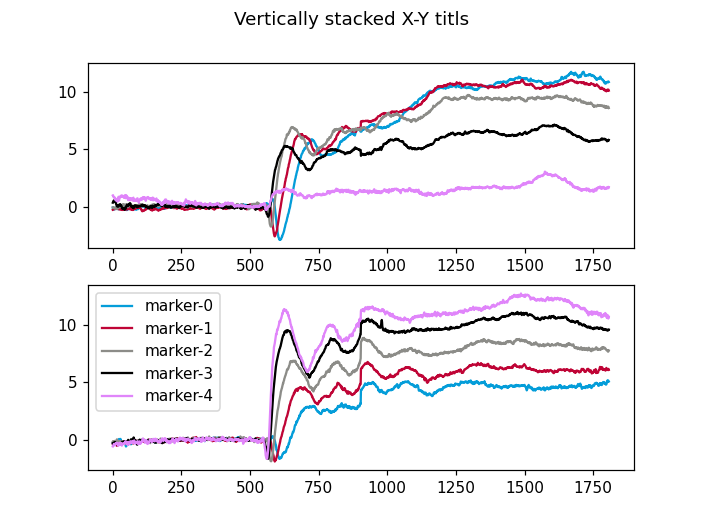

<IPython.core.display.Javascript object>


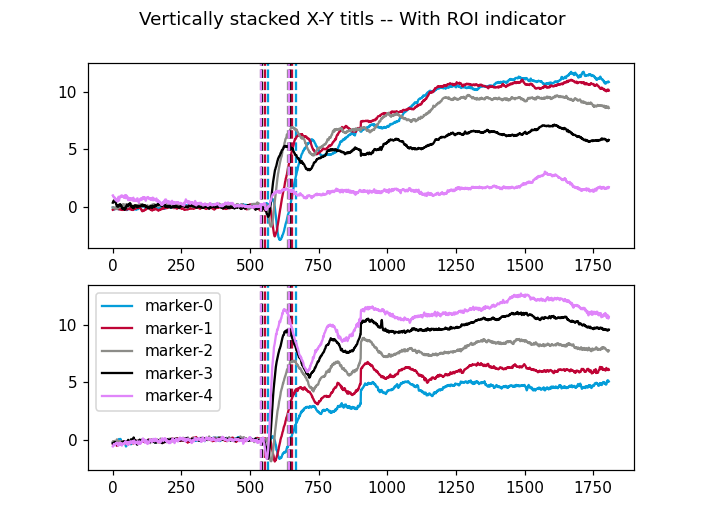

=> start frame for marker-0 is: 567
=> start frame for marker-1 is: 553
=> start frame for marker-2 is: 539
=> start frame for marker-3 is: 544
=> start frame for marker-4 is: 541


In [9]:
tgt_ind      = 2 # point index
exp_index    = 1 # at each target point, I repeat the knock 2-3 times, this index controls which repeat to load

# how many markers you want to show? 
marker_inds = [0,1,2,3,4]
m_location = [marker_locations[i] for i in marker_inds]

# mar_names = [marker_names[i] for i in marker_inds]
mar_names = ['marker-{}'.format(i) for i in marker_inds]

signal_list_list = []
for i in range(len(all_signal_list)):
    dist_ = (gt_loc_list[tgt_ind] - gt_locations_list[i]) ** 2
    
    dist_ = np.sum(dist_)
    if dist_ < 1e-1:
        signal_list_list.append([all_signal_list[i][m_ind] for m_ind in marker_inds])



# hyperparameter for detecting the arrival time of the transient waves using the thresholding algorithms 
#   as described in Eq(13) of the main paper
start_cfg = {
'std_coe': 20, 'smoothing_wsize':8, 'forward_window_size': 40,}

print("=> showing {}/{} repeat".format(exp_index + 1, len(signal_list_list)))        
signal_list = signal_list_list[exp_index]

pred_start_index_list = [
    signal_.get_start_index(**start_cfg) for signal_ in signal_list
                        ]

# plot the signal 
plot_signals(signal_list, label_list=mar_names, start_index_list=pred_start_index_list, window_size=100)


# Localization through the backprojection

In [10]:
drawing_cfg=dict(
    name="weighted_cone",
    fov=6,
    thickness=-1,
    weighting_by_scale=False,
    weighting_by_uncertainty=False,
    cone_weighting=0.04,
)


proj_theta_cfg=dict(
            std_coe=15.0,
            smoothing_wsize=8,
            forward_window_size=40,
            if_normalize=False,
            start_index=-1,           # use threshoulding to detect arrival time of waves automatically
            offset=20,
            window_size=120,
            stability_window_size=50, # not used 
            drawing_cfg=drawing_cfg,
            pre_size=10,
            safe_interval=10,
            weighting_cfg={'name': 'poly', 'params': [1.0]},  # Linear backprojection, no filtering
            global_start=False,
        )

# you might need to change the canvas size and position of marker_offset to position every items
#   in approperitae locations on the canvas

marker_scaling = 12 # scale the canvas size by 12. 

proj_solver = BackProjSolver(m_location, marker_scaling=12, canvas_size=[700, 700], 
                             angle_mapping_obj=angle_mapping_obj, theta_cfg=proj_theta_cfg, 
                             corner_locations=None, marker_offset=[0, -200], marker_center=np.array([0, 0]))


[0 0]
corner locations on canvas. tl. br
None


[565 552 538 542 540]


<IPython.core.display.Javascript object>


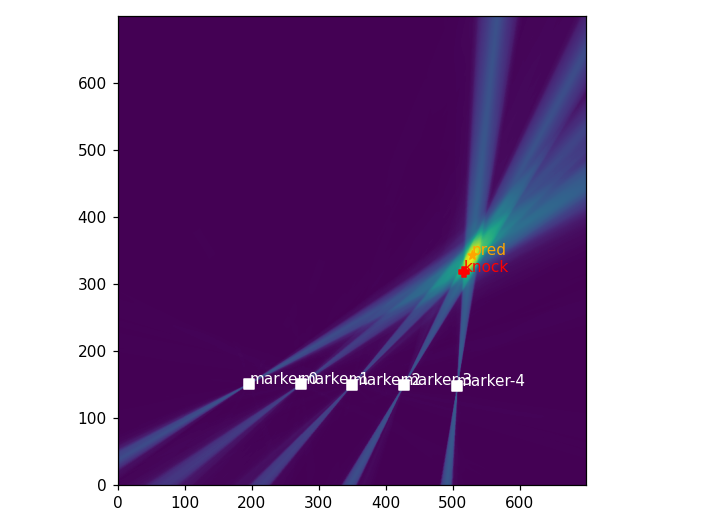

MSE: 2.33


In [11]:
# specify the starting time of the stable period by changing this variables 
hand_start_index_list = None # 
pred_xy, heat_map, plot_marker_locations, plot_pred_xy, img_gt_loc = proj_solver.pred_and_plot_polish(signal_list, gt_loc=gt_loc_list[tgt_ind], debug=True, 
                          start_index_list=hand_start_index_list ) 
plt.tight_layout()


gt_loc = gt_loc_list[tgt_ind]

mse = np.sqrt( ((gt_loc - pred_xy) ** 2).sum())
print('MSE: {:.2f}'.format(mse))
